Iniciant l'entrenament...
Època 1, Cost: 0.4800
Època 2, Cost: 0.4808
Època 3, Cost: 0.4774
Època 4, Cost: 0.4742
Època 5, Cost: 0.4712
Època 6, Cost: 0.4686
Època 7, Cost: 0.4640
Època 8, Cost: 0.4600
Època 9, Cost: 0.4532
Època 10, Cost: 0.4540

Prediccions finals:
Input: [0.55784233 0.12654082], Classe predita: 1, Probabilitat: 0.86
Input: [0.30950413 0.70863265], Classe predita: 1, Probabilitat: 0.95
Input: [ 0.59057369 -0.3090424 ], Classe predita: 1, Probabilitat: 0.83
Input: [ 0.30044434 -0.04786335], Classe predita: 1, Probabilitat: 0.92
Input: [-0.03264067  0.12984265], Classe predita: 1, Probabilitat: 0.99
Input: [0.04555058 0.45988166], Classe predita: 1, Probabilitat: 0.98
Input: [0.24066126 0.03847702], Classe predita: 1, Probabilitat: 0.94
Input: [0.14036188 0.10551709], Classe predita: 1, Probabilitat: 0.95
Input: [ 0.47246929 -0.06487674], Classe predita: 1, Probabilitat: 0.88
Input: [ 0.0990007  -0.27008879], Classe predita: 1, Probabilitat: 0.96
Input: [-0.80732627  0

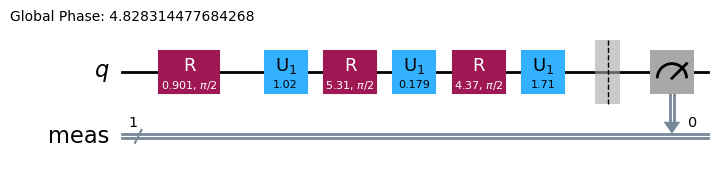

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime import Session
from qiskit_ibm_runtime import SamplerV2 as Sampler

# ---------------------------
# Generació de les dades
# ---------------------------

# Configurem la llavor per reproductibilitat
np.random.seed(0)
num_samples = 20

# Creem dues classes: cada una és una distribució gaussiana centrada a (0,0) i (1,1)
X_class0 = np.random.multivariate_normal([0, 0], [[0.1, 0], [0, 0.1]], num_samples)
X_class1 = np.random.multivariate_normal([1, 1], [[0.1, 0], [0, 0.1]], num_samples)

# Juntem les dades de les dues classes
X_train = np.vstack((X_class0, X_class1))
y_train = np.hstack((np.zeros(num_samples), np.ones(num_samples)))

# ---------------------------
# Definició dels circuits
# ---------------------------

def feature_map(x):
    """
    Codifica una mostra d'entrada 'x' al circuit quàntic mitjançant rotacions Ry i Rz.
    """
    qc = QuantumCircuit(1)
    qc.ry(x[0], 0)
    qc.rz(x[1], 0)
    return qc

def variational_circuit(params):
    """
    Circuit variacional amb paràmetres 'params'.
    Aplica una seqüència de rotacions Ry i Rz al qubit 0.
    """
    qc = QuantumCircuit(1)
    for i in range(len(params) // 2):
        qc.ry(params[2*i], 0)
        qc.rz(params[2*i + 1], 0)
    return qc

def construct_circuit(x, params):
    """
    Construeix el circuit complet combinant el feature map amb el circuit variacional.
    Finalment afegeix una mesura.
    """
    qc = QuantumCircuit(1)
    qc.compose(feature_map(x), inplace=True)
    qc.compose(variational_circuit(params), inplace=True)
    qc.measure_all()
    return qc

# ---------------------------
# Funció de cost
# ---------------------------

def cost(params, X, y, sampler):
    """
    Calcula el cost (square loss) entre les prediccions del circuit i les etiquetes reals.
    """
    total_loss = 0
    for xi, yi in zip(X, y):
        qc = construct_circuit(xi, params)
        result = sampler.run([qc]).result()
        counts = result[0].data.meas.get_counts()
        
        # Calculem la probabilitat que la mesura sigui '1'
        prob_1 = counts.get('1', 0) / sum(counts.values())
        
        # Square loss
        total_loss += (prob_1 - yi) ** 2
    return total_loss / len(X)

# ---------------------------
# Entrenament del model
# ---------------------------

# Inicialitzem els paràmetres aleatòriament (4 paràmetres per un circuit senzill)
params = np.random.uniform(0, 2 * np.pi, 4)

# Definim els hiperparàmetres de l'entrenament
epochs = 10
alpha = 0.1   # taxa d'aprenentatge
delta = 0.01  # pas per calcular el gradient numèric

# Configurem el simulador
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)

sampler = Sampler(mode=aer_sim)
print("Iniciant l'entrenament...")

# Entrenem durant un nombre determinat d'èpoques
for epoch in range(epochs):
    grads = np.zeros_like(params)
    
    # Calculem el gradient numèric per a cada paràmetre
    for i in range(len(params)):
        plus_params = np.copy(params)
        minus_params = np.copy(params)
        plus_params[i] += delta
        minus_params[i] -= delta

        grads[i] = (
            cost(plus_params, X_train, y_train, sampler)
            - cost(minus_params, X_train, y_train, sampler)
        ) / (2 * delta)
    
    # Actualitzem els paràmetres (gradient descent)
    params -= alpha * grads

    # Calculem el cost actual per fer seguiment
    curr_cost = cost(params, X_train, y_train, sampler)
    print(f"Època {epoch + 1}, Cost: {curr_cost:.4f}")

# ---------------------------
# Test després de l'entrenament
# ---------------------------

print("\nPrediccions finals:")
for xi in X_train:
    qc = construct_circuit(xi, params)
    result = sampler.run([qc]).result()
    bit_array = result[0].data.meas
    counts = bit_array.get_counts()
    
    prob_1 = counts.get('1', 0) / sum(counts.values())
    predicted_class = int(prob_1 > 0.5)
    print(f"Input: {xi}, Classe predita: {predicted_class}, Probabilitat: {prob_1:.2f}")

# ---------------------------
# Visualització del circuit
# ---------------------------

# Mostrem el circuit descompost (per veure totes les operacions individuals)
qc.decompose().draw('mpl')


In [2]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

In [3]:
# Example error probabilities
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

print(noise_bit_flip)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'cx', 'reset', 'u1', 'u3', 'measure']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


In [4]:
# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_bit_flip)

NameError: name 'circ' is not defined

Iniciant l'entrenament...
Època 1, Cost: 0.3868
Època 2, Cost: 0.3798
Època 3, Cost: 0.3858
Època 4, Cost: 0.3828
Època 5, Cost: 0.3785
Època 6, Cost: 0.3832
Època 7, Cost: 0.3805
Època 8, Cost: 0.3822
Època 9, Cost: 0.3795
Època 10, Cost: 0.3788

Prediccions finals:
Input: [0.55784233 0.12654082], Classe predita: 1, Probabilitat: 0.79
Input: [0.30950413 0.70863265], Classe predita: 1, Probabilitat: 0.81
Input: [ 0.59057369 -0.3090424 ], Classe predita: 1, Probabilitat: 0.75
Input: [ 0.30044434 -0.04786335], Classe predita: 1, Probabilitat: 0.79
Input: [-0.03264067  0.12984265], Classe predita: 1, Probabilitat: 0.85
Input: [0.04555058 0.45988166], Classe predita: 1, Probabilitat: 0.84
Input: [0.24066126 0.03847702], Classe predita: 1, Probabilitat: 0.85
Input: [0.14036188 0.10551709], Classe predita: 1, Probabilitat: 0.83
Input: [ 0.47246929 -0.06487674], Classe predita: 1, Probabilitat: 0.76
Input: [ 0.0990007  -0.27008879], Classe predita: 1, Probabilitat: 0.83
Input: [-0.80732627  0

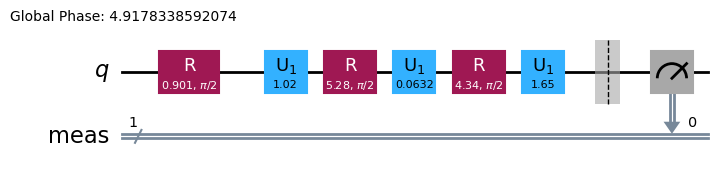

In [6]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime import Session
from qiskit_ibm_runtime import SamplerV2 as Sampler

# ---------------------------
# Generació de les dades
# ---------------------------

# Configurem la llavor per reproductibilitat
np.random.seed(0)
num_samples = 20

# Creem dues classes: cada una és una distribució gaussiana centrada a (0,0) i (1,1)
X_class0 = np.random.multivariate_normal([0, 0], [[0.1, 0], [0, 0.1]], num_samples)
X_class1 = np.random.multivariate_normal([1, 1], [[0.1, 0], [0, 0.1]], num_samples)

# Juntem les dades de les dues classes
X_train = np.vstack((X_class0, X_class1))
y_train = np.hstack((np.zeros(num_samples), np.ones(num_samples)))

# ---------------------------
# Definició dels circuits
# ---------------------------

def feature_map(x):
    """
    Codifica una mostra d'entrada 'x' al circuit quàntic mitjançant rotacions Ry i Rz.
    """
    qc = QuantumCircuit(1)
    qc.ry(x[0], 0)
    qc.rz(x[1], 0)
    return qc

def variational_circuit(params):
    """
    Circuit variacional amb paràmetres 'params'.
    Aplica una seqüència de rotacions Ry i Rz al qubit 0.
    """
    qc = QuantumCircuit(1)
    for i in range(len(params) // 2):
        qc.ry(params[2*i], 0)
        qc.rz(params[2*i + 1], 0)
    return qc

def construct_circuit(x, params):
    """
    Construeix el circuit complet combinant el feature map amb el circuit variacional.
    Finalment afegeix una mesura.
    """
    qc = QuantumCircuit(1)
    qc.compose(feature_map(x), inplace=True)
    qc.compose(variational_circuit(params), inplace=True)
    qc.measure_all()
    return qc

# ---------------------------
# Funció de cost
# ---------------------------

def cost(params, X, y, sampler, sim):
    """
    Calcula el cost (square loss) entre les prediccions del circuit i les etiquetes reals.
    """
    total_loss = 0
    for xi, yi in zip(X, y):
        qc = construct_circuit(xi, params)
        tran_qc = transpile(qc, sim)
        result = sampler.run([tran_qc]).result()
        counts = result[0].data.meas.get_counts()
        
        # Calculem la probabilitat que la mesura sigui '1'
        prob_1 = counts.get('1', 0) / sum(counts.values())
        
        # Square loss
        total_loss += (prob_1 - yi) ** 2
    return total_loss / len(X)

# ---------------------------
# Entrenament del model
# ---------------------------

# Inicialitzem els paràmetres aleatòriament (4 paràmetres per un circuit senzill)
params = np.random.uniform(0, 2 * np.pi, 4)

# Definim els hiperparàmetres de l'entrenament
epochs = 10
alpha = 0.1   # taxa d'aprenentatge
delta = 0.01  # pas per calcular el gradient numèric

# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_bit_flip)
pm = generate_preset_pass_manager(backend=sim_noise, optimization_level=1)

sampler = Sampler(mode=sim_noise)
print("Iniciant l'entrenament...")

# Entrenem durant un nombre determinat d'èpoques
for epoch in range(epochs):
    grads = np.zeros_like(params)
    
    # Calculem el gradient numèric per a cada paràmetre
    for i in range(len(params)):
        plus_params = np.copy(params)
        minus_params = np.copy(params)
        plus_params[i] += delta
        minus_params[i] -= delta

        grads[i] = (
            cost(plus_params, X_train, y_train, sampler, sim_noise)
            - cost(minus_params, X_train, y_train, sampler, sim_noise)
        ) / (2 * delta)
    
    # Actualitzem els paràmetres (gradient descent)
    params -= alpha * grads

    # Calculem el cost actual per fer seguiment
    curr_cost = cost(params, X_train, y_train, sampler, sim_noise)
    print(f"Època {epoch + 1}, Cost: {curr_cost:.4f}")

# ---------------------------
# Test després de l'entrenament
# ---------------------------

print("\nPrediccions finals:")
for xi in X_train:
    qc = construct_circuit(xi, params)
    tran_qc = transpile(qc, sim_noise)
    result = sampler.run([tran_qc]).result()
    bit_array = result[0].data.meas
    counts = bit_array.get_counts()
    
    prob_1 = counts.get('1', 0) / sum(counts.values())
    predicted_class = int(prob_1 > 0.5)
    print(f"Input: {xi}, Classe predita: {predicted_class}, Probabilitat: {prob_1:.2f}")

# ---------------------------
# Visualització del circuit
# ---------------------------

# Mostrem el circuit descompost (per veure totes les operacions individuals)
qc.decompose().draw('mpl')


## Introducció general

El codi presentat implementa un **Variational Quantum Classifier (VQC)** emprant la llibreria Qiskit. L'objectiu d'aquest model és classificar dades binàries a partir d'un conjunt sintètic de punts generats al voltant de dues mitjanes diferenciades. La idea central dels VQC és utilitzar circuits quàntics parametritzats per tal de transformar dades clàssiques en un espai de característiques d'alta dimensió, i a través de la mesura final, obtenir una predicció de la classe. Aquest enfocament forma part de la branca emergent del **Quantum Machine Learning (QML)**, que pretén aprofitar les propietats de la mecànica quàntica (com l'entanglement i la superposició) per abordar problemes complexos de classificació o regressió.

## Generació de dades

La primera part del codi genera **dades sintètiques** de dues classes utilitzant distribucions normals multivariants. En concret, es generen dos grups de 20 punts cadascun, al voltant dels centres $[0,0]$ i $[1,1]$, amb poca variància per garantir que les classes siguin inicialment separables. Aquestes dades són representades per dues matrius: `X_train` (les característiques) i `y_train` (les etiquetes corresponents: 0 o 1).

Aquest tipus de dataset és habitual en tests de models inicials perquè permet validar la **capacitat del model d'aprendre patrons simples** abans d'escalar a problemes més complexos.

## Feature map

El **feature map** és la primera etapa crítica del VQC. La funció `feature_map(x)` transforma cada punt de dades clàssiques en un estat quàntic. Aquesta transformació s'implementa mitjançant:

* Una rotació Ry controlada pel primer element de la mostra $x[0]$,
* Una rotació Rz controlada pel segon element $x[1]$.

Tot això es realitza sobre un únic qubit. La funció retorna un circuit quàntic que **codifica la informació clàssica** en un estat quàntic, permetent que les dades entrin dins l'espai quàntic. Aquesta etapa és fonamental perquè la **riquesa de l'espai de característiques** en QML depèn molt del tipus d'encodat triat.


## Variational circuit

La segona part essencial és el **circuit variacional**. La funció `variational_circuit(params)` defineix un circuit quàntic també sobre un únic qubit, on s'apliquen rotacions Ry i Rz parametritzades. Els paràmetres (`params`) són **valors ajustables durant l'entrenament**, i són precisament aquests els que el model optimitza per trobar la millor frontera de decisió. En aquest cas, es defineixen dues capes (amb 4 paràmetres en total), que permeten certa flexibilitat per ajustar el model a les dades.

El concepte fonamental aquí és que, igual que en les xarxes neuronals clàssiques, aquestes rotacions **actuen com a "pesos"** del model que són entrenats mitjançant descens de gradient.


## Composició del circuit

La funció `construct_circuit(x, params)` combina les dues parts anteriors:

1. Primer, compon el feature map per codificar la mostra.
2. Després, afegeix el circuit variacional sobre el mateix qubit.
3. Finalment, s'afegeix una instrucció de mesura (`qc.measure_all()`) per garantir que el simulador pugui mesurar l'estat quàntic final.

El resultat és un circuit complet que, donada una entrada `x` i uns paràmetres `params`, està llest per ser executat i retornar un resultat mesurable (clàssic).


## Funció de cost

La funció `cost(params, X, y, sampler)` és la **funció de pèrdua (loss function)** del model. Aquesta funció calcula l'error quadràtic mitjà (MSE) entre la probabilitat mesurada de trobar el qubit en l'estat $|1\rangle$ i la classe esperada (0 o 1). Concretament:

* S'executa el circuit per cada mostra,
* Es mesura el circuit utilitzant el `Sampler` de Qiskit (que simula el comportament del circuit),
* Es recullen els comptatges i es calcula la probabilitat d'obtenir l'estat '1',
* Aquesta probabilitat es compara amb l'etiqueta real per calcular l'error.

L'ús del **MSE** és habitual en models de classificació binària quan es tracta de probabilitats, tot i que altres funcions com la cross-entropy també serien vàlides.


## Entrenament

L'entrenament s'implementa mitjançant un **descens de gradient numèric simple**. Per cada època:

* Es calcula la derivada numèrica de la funció de cost respecte a cada paràmetre utilitzant la tècnica de **central difference** (aproximació de la derivada).
* S'actualitzen els paràmetres seguint la regla del descens de gradient:

$$
θ_{new} = θ_{old} - α \cdot gradient
$$

on $α$ és la taxa d'aprenentatge.

Aquest procés es repeteix durant 10 èpoques. La pèrdua es redueix progressivament, fent que el circuit variacional s'ajusti millor a les dades d'entrenament.


## Predicció

Després de l'entrenament, el model és testejat sobre el mateix conjunt d'entrenament. Es reconstrueix el circuit per a cada mostra i s'executa per obtenir la probabilitat final de trobar el qubit en l'estat '1'. Si aquesta probabilitat supera 0.5, es considera que la predicció del model és la classe 1; en cas contrari, classe 0. Aquestes prediccions es comparen amb les etiquetes reals per veure la precisió del model.


## Visualització

Finalment, es fa una crida a `qc.decompose().draw('mpl')` que permet visualitzar la descomposició del circuit quàntic en una imatge. Aquesta visualització ajuda a **comprovar l'estructura real del circuit**, mostrant les rotacions i mesures aplicades.


## Conclusions

Aquest codi és un **exemple complet d'un VQC minimalista**, i tot i operar sobre un únic qubit, demostra els components essencials d’un model QML:

* La codificació de dades en l'espai quàntic,
* La parametrització i optimització del circuit,
* La mesura per obtenir una sortida clàssica.

Les avantatges d'aquest enfocament rauen en la possibilitat d'explorar **espais de característiques més rics** i introduir **no-linealitats complexes** d'una manera natural. Tot i això, cal remarcar que, amb 1 qubit i un dataset simple, aquest model serveix sobretot com a **prova de concepte** i base per a futurs experiments més sofisticats (amb més qubits, entanglement i datasets reals).


Iniciant entrenament...
Època 1, Cost: 0.1958
Època 2, Cost: 0.1927
Època 3, Cost: 0.1916
Època 4, Cost: 0.1876
Època 5, Cost: 0.1863
Època 6, Cost: 0.1840
Època 7, Cost: 0.1838
Època 8, Cost: 0.1826
Època 9, Cost: 0.1829
Època 10, Cost: 0.1829

Prediccions finals:
Input: [0.2962963 0.625    ], Classe predita: 0, Probabilitat: 0.37
Input: [0.22222222 0.41666667], Classe predita: 0, Probabilitat: 0.34
Input: [0.14814815 0.5       ], Classe predita: 0, Probabilitat: 0.30
Input: [0.11111111 0.45833333], Classe predita: 0, Probabilitat: 0.33
Input: [0.25925926 0.66666667], Classe predita: 0, Probabilitat: 0.41
Input: [0.40740741 0.79166667], Classe predita: 0, Probabilitat: 0.46
Input: [0.11111111 0.58333333], Classe predita: 0, Probabilitat: 0.29
Input: [0.25925926 0.58333333], Classe predita: 0, Probabilitat: 0.34
Input: [0.03703704 0.375     ], Classe predita: 0, Probabilitat: 0.28
Input: [0.22222222 0.45833333], Classe predita: 0, Probabilitat: 0.34
Input: [0.40740741 0.70833333], Clas

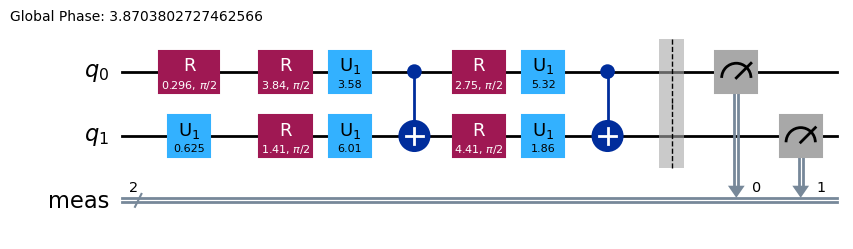

In [7]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime import Session
from qiskit_ibm_runtime import SamplerV2 as Sampler

# ---------------------------
# Generació de dades
# ---------------------------

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

# Carreguem Iris dataset i filtrem classes 0 i 1
iris = load_iris()
X = iris.data
y = iris.target

mask = y < 2
X = X[mask]
y = y[mask]

# Agafem només dues característiques: sepal length i sepal width
X = X[:, :2]

# Normalitzem
scaler = StandardScaler()
X_train = scaler.fit_transform(X)
y_train = y

# Mapeig simple: de [-a, a] → [0, π]
X_train = (X_train - X_train.min(axis=0)) / (X_train.max(axis=0) - X_train.min(axis=0))

# ---------------------------
# Definició del circuit quàntic
# ---------------------------

def feature_map(x):
    """
    Feature map per 2 qubits: codifica les dades 'x' al circuit quàntic
    aplicant Ry i Rz en qubits diferents.
    """
    qc = QuantumCircuit(2)
    qc.ry(x[0], 0)
    qc.rz(x[1], 1)
    return qc

def variational_circuit(params, entangle=False):
    """
    Circuit variacional per 2 qubits amb paràmetres 'params'.
    Cada capa aplica Ry i Rz a cada qubit, amb opció d'entrellaçar-los.
    """
    qc = QuantumCircuit(2)
    num_layers = len(params) // 4  # 4 paràmetres per capa (2 per cada qubit)
    for l in range(num_layers):
        qc.ry(params[4 * l + 0], 0)
        qc.rz(params[4 * l + 1], 0)
        qc.ry(params[4 * l + 2], 1)
        qc.rz(params[4 * l + 3], 1)
        if entangle:
            qc.cx(0, 1)  # afegim entrellaçament si està activat
    return qc

def construct_circuit(x, params, entangle=False):
    """
    Construeix el circuit complet: feature map + circuit variacional + mesura.
    """
    qc = QuantumCircuit(2)
    qc.compose(feature_map(x), inplace=True)
    qc.compose(variational_circuit(params, entangle=entangle), inplace=True)
    qc.measure_all()
    return qc

# ---------------------------
# Funció de cost
# ---------------------------

def cost(params, X, y, sampler, entangle=False):
    """
    Calcula el cost (square loss) basat en la diferència entre la predicció
    del circuit i l'etiqueta real.
    """
    total_loss = 0
    for xi, yi in zip(X, y):
        qc = construct_circuit(xi, params, entangle=entangle)
        result = sampler.run([qc]).result()
        bit_array = result[0].data.meas
        counts = bit_array.get_counts()
        
        # Considerem que la classe '1' correspon als estats on el qubit 0 és '1'
        prob_1 = (
            counts.get('01', 0) +
            counts.get('11', 0)
        ) / sum(counts.values())
        
        # Square loss
        total_loss += (prob_1 - yi) ** 2
    return total_loss / len(X)

# ---------------------------
# Entrenament del model
# ---------------------------

# Inicialitzem els paràmetres (2 qubits -> 4 params per capa, aquí fem 2 capes)
params = np.random.uniform(0, 2 * np.pi, 8)

# Hiperparàmetres
epochs = 10
alpha = 0.1    # taxa d'aprenentatge
delta = 0.01   # pas per calcular gradients numèrics
entangle = True  # podem activar o desactivar entrellaçament

# Configurem el simulador quàntic
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)

# Executem l'entrenament dins una sessió amb el SamplerV2
with Session(backend=aer_sim) as session:
    sampler = Sampler(mode=session)
    print("Iniciant entrenament...")

    for epoch in range(epochs):
        grads = np.zeros_like(params)
        
        # Calcul de gradients numèrics (finite difference)
        for i in range(len(params)):
            plus_params = np.copy(params)
            minus_params = np.copy(params)
            plus_params[i] += delta
            minus_params[i] -= delta
            grads[i] = (
                cost(plus_params, X_train, y_train, sampler, entangle)
                - cost(minus_params, X_train, y_train, sampler, entangle)
            ) / (2 * delta)
        
        # Actualització dels paràmetres (gradient descent)
        params -= alpha * grads

        # Calculem el cost actual per monitoritzar l'evolució
        curr_cost = cost(params, X_train, y_train, sampler, entangle)
        print(f"Època {epoch + 1}, Cost: {curr_cost:.4f}")

    # ---------------------------
    # Test després d'entrenar
    # ---------------------------

    print("\nPrediccions finals:")
    for xi in X_train:
        qc = construct_circuit(xi, params, entangle=entangle)
        result = sampler.run([qc]).result()
        bit_array = result[0].data.meas
        counts = bit_array.get_counts()
        
        prob_1 = (
            counts.get('01', 0) +
            counts.get('11', 0)
        ) / sum(counts.values())
        predicted_class = int(prob_1 > 0.5)
        #print(f"Input: {xi}, Classe predita: {predicted_class}, Probabilitat: {prob_1:.2f}")

# ---------------------------
# Visualització del circuit
# ---------------------------

# Visualitzem el circuit descompost d'un exemple
example_circuit = construct_circuit(X_train[0], params, entangle=entangle)
example_circuit.decompose().draw('mpl')



## Implementació amb dos qubits
En aquesta versió del model, s’ha ampliat el circuit per treballar amb 2 qubits en lloc d’un, fet que suposa un pas important cap a una codificació més expressiva i una major capacitat de representació. L’ús de 2 qubits permet codificar diferents components de la mostra en qubits separats mitjançant rotacions específiques (Ry i Rz), i a més introdueix la possibilitat d’incorporar entanglement mitjançant portes de control (com la CX). Aquest canvi permet capturar correlacions entre característiques que no serien accessibles amb un sol qubit. A nivell de circuit, això implica una major complexitat, ja que el nombre de paràmetres del circuit variacional augmenta i la mesura final ha de considerar bitstrings de dues posicions. Per exemple, per predir la probabilitat de la classe positiva, es considera la presència del valor '1' en el primer qubit, agrupant les sortides '01' i '11'. Aquesta configuració permet començar a explorar els avantatges potencials dels sistemes multiqubit en classificació quàntica.

En aquesta etapa s’ha utilitzat el dataset Iris filtrant les classes 0 i 1 per crear un problema de classificació binària amb dues característiques (longitud i amplada del sèpal). Després de normalitzar les dades amb StandardScaler, s’ha aplicat un reescalat addicional per ajustar-les al rang [0,1][0,1], preparant-les així per ser codificades com a angles de rotació en el circuit quàntic. Aquesta transformació assegura que els valors d’entrada siguin compatibles amb la representació quàntica i permet una codificació estable dins el circuit.

Starting training...
Epoch 1, Cost: 0.2005
Epoch 2, Cost: 0.1993
Epoch 3, Cost: 0.1997
Epoch 4, Cost: 0.1992
Epoch 5, Cost: 0.1984
Epoch 6, Cost: 0.1988
Epoch 7, Cost: 0.1986
Epoch 8, Cost: 0.1980
Epoch 9, Cost: 0.1965
Epoch 10, Cost: 0.1964

Predictions with true labels and accuracy check:
Input: [1.63688738 0.07118252 1.71527355 1.14270019 1.8653295  2.48825856
 2.20897834 2.29686024 2.15627496 1.90229126], True class: 0, Predicted: 0, Probability: 0.23
Input: [2.02049802 0.85631508 1.93454026 1.57579356 0.91068466 0.57104098
 0.63965417 1.09565386 1.19317054 0.44397824], True class: 0, Predicted: 0, Probability: 0.41
Input: [1.88965408 1.2260392  1.87158249 1.41188438 1.61574915 1.35407828
 1.45302341 1.99706611 1.60094292 0.66365152], True class: 0, Predicted: 0, Probability: 0.25
Input: [0.66001845 1.13360817 0.73356655 0.32328754 2.54883932 2.54896659
 1.77689894 1.642622   2.43870096 3.14159265], True class: 0, Predicted: 0, Probability: 0.04
Input: [1.97886585 0.49190308 1.9823

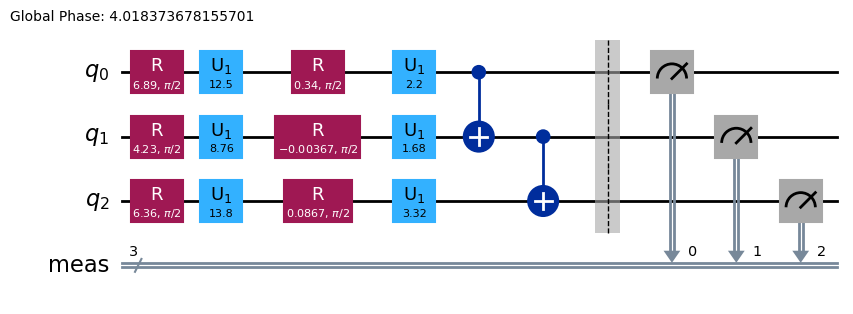

In [5]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session
from qiskit_ibm_runtime import SamplerV2 as Sampler

# ---------------------------
# Configuració inicial
# ---------------------------

# Definim el nombre de qubits (es pot modificar fàcilment)
n_qubits = 3

# ---------------------------
# Generació i preparació de dades
# ---------------------------

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

# Carreguem el dataset Breast Cancer
data = load_breast_cancer()
X = data.data
y = data.target

# Seleccionem les primeres 10 característiques (podríem ampliar-ho segons el cas)
X = X[:, :10]

# Normalització: ajustem cada característica a mitjana 0 i desviació estàndard 1
scaler = StandardScaler()
X_train = scaler.fit_transform(X)
y_train = y

# Escalem les dades al rang [0, π] per codificar-les com a angles quàntics
X_train = (X_train - X_train.min(axis=0)) / (X_train.max(axis=0) - X_train.min(axis=0)) * np.pi

# ---------------------------
# Feature map (codificació de les dades)
# ---------------------------

def feature_map(x, n_qubits):
    """
    Feature map simple: assigna les features a Ry segons el qubit corresponent.
    Si hi ha més features que qubits, combina-les per suma.
    """
    qc = QuantumCircuit(n_qubits)
    for i in range(n_qubits):
        angle = sum(x[j] for j in range(i, len(x), n_qubits))
        qc.ry(angle, i)
    return qc

def feature_map_v2(x, n_qubits):
    """
    Feature map millorat: combina rotacions Ry i Rz, amb opcional quadràtica.
    Afegeix més riquesa a la codificació de les dades.
    """
    qc = QuantumCircuit(n_qubits)
    for i in range(n_qubits):
        angle_y = sum(x[j] for j in range(i, len(x), n_qubits))
        angle_z = sum(x[j]**2 for j in range(i, len(x), n_qubits))
        qc.ry(angle_y, i)
        qc.rz(angle_z, i)
    return qc

# ---------------------------
# Circuit variacional
# ---------------------------

def variational_circuit(params, n_qubits, entangle=False):
    """
    Circuit variacional amb Ry i Rz per cada qubit i capa.
    Pot incloure entrellaçament mitjançant portes CX si entangle=True.
    """
    qc = QuantumCircuit(n_qubits)
    num_layers = len(params) // (2 * n_qubits)
    for l in range(num_layers):
        for q in range(n_qubits):
            qc.ry(params[2 * n_qubits * l + 2 * q], q)
            qc.rz(params[2 * n_qubits * l + 2 * q + 1], q)
        if entangle:
            for q in range(n_qubits - 1):
                qc.cx(q, q + 1)
    return qc

# ---------------------------
# Circuit complet
# ---------------------------

def construct_circuit(x, params, n_qubits, entangle=False):
    """
    Construeix el circuit final combinant feature map i circuit variacional.
    """
    qc = QuantumCircuit(n_qubits)
    qc.compose(feature_map_v2(x, n_qubits), inplace=True)
    qc.compose(variational_circuit(params, n_qubits, entangle=entangle), inplace=True)
    qc.measure_all()
    return qc

# ---------------------------
# Funció de cost
# ---------------------------

def cost(params, X, y, sampler, n_qubits, entangle=False):
    """
    Calcula la square loss entre la probabilitat estimada i la classe real.
    S’utilitza la probabilitat que el primer qubit estigui en estat '1'.
    """
    total_loss = 0
    for xi, yi in zip(X, y):
        qc = construct_circuit(xi, params, n_qubits, entangle=entangle)
        result = sampler.run([qc]).result()
        bit_array = result[0].data.meas
        counts = bit_array.get_counts()
        total_counts = sum(counts.values())

        # Calculem la probabilitat de '1' al primer qubit (últim bit del string)
        prob_1 = sum(count for bitstring, count in counts.items() if bitstring[-1] == '1')
        prob_1 /= total_counts

        total_loss += (prob_1 - yi) ** 2
    return total_loss / len(X)

# ---------------------------
# Entrenament
# ---------------------------

num_layers = 1
num_params = num_layers * 2 * n_qubits  # Cada capa té 2 paràmetres per qubit
params = np.random.uniform(0, 2 * np.pi, num_params)

epochs = 10
alpha = 0.1    # Taxa d'aprenentatge
delta = 0.01   # Increment per al gradient numèric
entangle = True  # Entrellaçament activat

# Configuració del simulador
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)

# Entrenament dins la sessió
with Session(backend=aer_sim) as session:
    sampler = Sampler(mode=session)
    print("Starting training...")
    for epoch in range(epochs):
        grads = np.zeros_like(params)
        for i in range(len(params)):
            plus_params = np.copy(params)
            minus_params = np.copy(params)
            plus_params[i] += delta
            minus_params[i] -= delta
            grads[i] = (cost(plus_params, X_train, y_train, sampler, n_qubits, entangle)
                        - cost(minus_params, X_train, y_train, sampler, n_qubits, entangle)) / (2 * delta)
        params -= alpha * grads
        curr_cost = cost(params, X_train, y_train, sampler, n_qubits, entangle)
        print(f"Epoch {epoch + 1}, Cost: {curr_cost:.4f}")

    # ---------------------------
    # Test i precisió final
    # ---------------------------

    print("\nPredictions with true labels and accuracy check:")
    correct = 0
    total = len(X_train)

    for xi, yi in zip(X_train, y_train):
        qc = construct_circuit(xi, params, n_qubits, entangle=entangle)
        result = sampler.run([qc]).result()
        bit_array = result[0].data.meas
        counts = bit_array.get_counts()
        total_counts = sum(counts.values())

        prob_1 = sum(count for bitstring, count in counts.items() if bitstring[-1] == '1')
        prob_1 /= total_counts
        predicted_class = int(prob_1 > 0.5)

        #print(f"Input: {xi}, True class: {yi}, Predicted: {predicted_class}, Probability: {prob_1:.2f}")
        if predicted_class == yi:
            correct += 1

    accuracy = correct / total * 100
    print(f"\nFinal accuracy: {correct}/{total} correct ({accuracy:.2f}%)")

# ---------------------------
# Visualització del circuit final
# ---------------------------

qc_test = construct_circuit(X_train[0], params, n_qubits, entangle=entangle)
qc_test.decompose().draw('mpl')




### **Ampliació a múltiples qubits i més característiques**

En aquesta versió ampliada del model, s’ha passat de circuits senzills a un circuit que utilitza **tres qubits**, cosa que permet treballar amb un nombre més gran de característiques. S’ha utilitzat el dataset *Breast Cancer* amb 10 característiques seleccionades, fet que permet avaluar el comportament del model en un entorn més realista i complex. Aquesta ampliació respon a la necessitat de superar limitacions dels models anteriors, que només podien gestionar un petit nombre de features, i mostra la flexibilitat del disseny per escalar en problemes més sofisticats.


### **Millores en la codificació i circuit variacional**

El **feature map** s’ha modificat per distribuir de manera eficient les característiques entre els qubits disponibles. Quan hi ha més característiques que qubits, les dades es combinen per suma, i s’han afegit també **rotacions quadràtiques (Rz)** per enriquir la codificació, capturant així relacions més complexes entre els valors d’entrada. El circuit variacional s’ha ajustat per aplicar rotacions Ry i Rz a cada qubit en cada capa, amb l’opció d’afegir entrellaçament (portes CX) per reforçar la capacitat expressiva del model, especialment important quan treballem amb dades d’alta dimensionalitat.


### **Avaluació i mesura de rendiment**

A més d'entrenar el model mitjançant **gradient descent numèric**, el codi ara calcula l’**accuracy final**, comparant les prediccions amb les etiquetes reals per donar una mesura quantitativa del rendiment. La predicció es basa en la probabilitat que el primer qubit mesurat estigui en estat ‘1’, combinant tots els resultats rellevants (‘01’, ‘11’, etc.). Aquesta ampliació permet no només veure la convergència de la funció de cost durant l’entrenament, sinó també comprovar la **precisió global del model** de manera objectiva, fent l’eina més completa per avaluar la classificació quàntica en datasets reals.



In [45]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()

for idx, name in enumerate(data.feature_names):
    print(f"{idx}: {name}")

0: mean radius
1: mean texture
2: mean perimeter
3: mean area
4: mean smoothness
5: mean compactness
6: mean concavity
7: mean concave points
8: mean symmetry
9: mean fractal dimension
10: radius error
11: texture error
12: perimeter error
13: area error
14: smoothness error
15: compactness error
16: concavity error
17: concave points error
18: symmetry error
19: fractal dimension error
20: worst radius
21: worst texture
22: worst perimeter
23: worst area
24: worst smoothness
25: worst compactness
26: worst concavity
27: worst concave points
28: worst symmetry
29: worst fractal dimension


Starting training...
Epoch 1, Cost: 0.1865
Epoch 2, Cost: 0.1851
Epoch 3, Cost: 0.1842
Epoch 4, Cost: 0.1816
Epoch 5, Cost: 0.1799
Epoch 6, Cost: 0.1789
Epoch 7, Cost: 0.1780
Epoch 8, Cost: 0.1766
Epoch 9, Cost: 0.1741
Epoch 10, Cost: 0.1733

Predictions with true labels and accuracy check:

Final accuracy: 333/398 correct (83.67%)


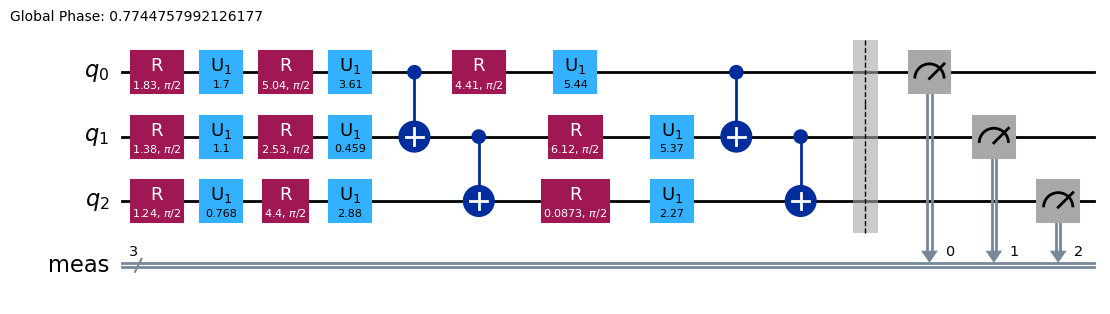

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session
from qiskit_ibm_runtime import SamplerV2 as Sampler

# ---------------------------
# Feature map (codificació de les dades)
# ---------------------------

def feature_map(x, n_qubits):
    """
    Feature map simple: assigna les features a Ry segons el qubit corresponent.
    Si hi ha més features que qubits, combina-les per suma.
    """
    qc = QuantumCircuit(n_qubits)
    for i in range(n_qubits):
        angle = sum(x[j] for j in range(i, len(x), n_qubits))
        qc.ry(angle, i)
    return qc

def feature_map_v2(x, n_qubits):
    """
    Feature map millorat: combina rotacions Ry i Rz, amb opcional quadràtica.
    Afegeix més riquesa a la codificació de les dades.
    """
    qc = QuantumCircuit(n_qubits)
    for i in range(n_qubits):
        angle_y = sum(x[j] for j in range(i, len(x), n_qubits))
        angle_z = sum(x[j]**2 for j in range(i, len(x), n_qubits))
        qc.ry(angle_y, i)
        qc.rz(angle_z, i)
    return qc

# ---------------------------
# Circuit variacional
# ---------------------------

def variational_circuit(params, n_qubits, entangle=False):
    """
    Circuit variacional amb Ry i Rz per cada qubit i capa.
    Pot incloure entrellaçament mitjançant portes CX si entangle=True.
    """
    qc = QuantumCircuit(n_qubits)
    num_layers = len(params) // (2 * n_qubits)
    for l in range(num_layers):
        for q in range(n_qubits):
            qc.ry(params[2 * n_qubits * l + 2 * q], q)
            qc.rz(params[2 * n_qubits * l + 2 * q + 1], q)
        if entangle:
            for q in range(n_qubits - 1):
                qc.cx(q, q + 1)
    return qc

# ---------------------------
# Circuit complet
# ---------------------------

def construct_circuit(x, params, n_qubits, entangle=False):
    """
    Construeix el circuit final combinant feature map i circuit variacional.
    """
    qc = QuantumCircuit(n_qubits)
    qc.compose(feature_map_v2(x, n_qubits), inplace=True)
    qc.compose(variational_circuit(params, n_qubits, entangle=entangle), inplace=True)
    qc.measure_all()
    return qc

# ---------------------------
# Funció de cost
# ---------------------------

def cost(params, X, y, sampler, n_qubits, entangle=False):
    """
    Calcula la square loss entre la probabilitat estimada i la classe real.
    S’utilitza la probabilitat que el primer qubit estigui en estat '1'.
    """
    total_loss = 0
    for xi, yi in zip(X, y):
        qc = construct_circuit(xi, params, n_qubits, entangle=entangle)
        result = sampler.run([qc]).result()
        bit_array = result[0].data.meas
        counts = bit_array.get_counts()
        total_counts = sum(counts.values())

        # Calculem la probabilitat de '1' al primer qubit (últim bit del string)
        prob_1 = sum(count for bitstring, count in counts.items() if bitstring[-1] == '1')
        prob_1 /= total_counts

        total_loss += (prob_1 - yi) ** 2
    return total_loss / len(X)
    
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Carreguem les dades
data = load_breast_cancer()

X = data.data
y = data.target  # 0 = malignant, 1 = benign

# Seleccionem només 2 o 3 features rellevants (per exemple, mean radius i mean texture)
selected_features = [0, 2, 3, 20, 23, 27]  # pots provar altres combinacions
X_selected = X[:, selected_features]

# Normalitzem entre [0, pi] per adaptar-ho a rotacions
scaler = MinMaxScaler(feature_range=(0, np.pi))
X_scaled = scaler.fit_transform(X_selected)

# Partició train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Nombre de qubits segons nombre de features
n_qubits = X_train.shape[1]


n_qubits = 3
num_layers = 2
num_params = num_layers * 2 * n_qubits  # Cada capa té 2 paràmetres per qubit
params = np.random.uniform(0, 2 * np.pi, num_params)

epochs = 10
alpha = 0.1    # Taxa d'aprenentatge
delta = 0.01   # Increment per al gradient numèric
entangle = True  # Entrellaçament activat
cost_history = []


# Configuració del simulador
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)

sampler = Sampler(mode=aer_sim)
print("Starting training...")
for epoch in range(epochs):
    grads = np.zeros_like(params)
    for i in range(len(params)):
        plus_params = np.copy(params)
        minus_params = np.copy(params)
        plus_params[i] += delta
        minus_params[i] -= delta
        grads[i] = (cost(plus_params, X_train, y_train, sampler, n_qubits, entangle)
                    - cost(minus_params, X_train, y_train, sampler, n_qubits, entangle)) / (2 * delta)
    params -= alpha * grads
    curr_cost = cost(params, X_train, y_train, sampler, n_qubits, entangle)
    cost_history.append(curr_cost)
    print(f"Epoch {epoch + 1}, Cost: {curr_cost:.4f}")

# ---------------------------
# Test i precisió final
# ---------------------------

print("\nPredictions with true labels and accuracy check:")
correct = 0
X_plot = []
y_true_plot = []
y_pred_plot = []
prob_1_plot = []

total = len(X_train)

for xi, yi in zip(X_train, y_train):
    qc = construct_circuit(xi, params, n_qubits, entangle=entangle)
    result = sampler.run([qc]).result()
    bit_array = result[0].data.meas
    counts = bit_array.get_counts()
    total_counts = sum(counts.values())

    prob_1 = sum(count for bitstring, count in counts.items() if bitstring[-1] == '1')
    prob_1 /= total_counts
    predicted_class = int(prob_1 > 0.5)
    X_plot.append(xi[0])  # O xi si vols fer un plot 2D
    y_true_plot.append(yi)
    y_pred_plot.append(predicted_class)
    prob_1_plot.append(prob_1)


    #print(f"Input: {xi}, True class: {yi}, Predicted: {predicted_class}, Probability: {prob_1:.2f}")
    if predicted_class == yi:
        correct += 1

accuracy = correct / total * 100
print(f"\nFinal accuracy: {correct}/{total} correct ({accuracy:.2f}%)")

# ---------------------------
# Visualització del circuit final
# ---------------------------

qc_test = construct_circuit(X_train[0], params, n_qubits, entangle=entangle)
qc_test.decompose().draw('mpl')

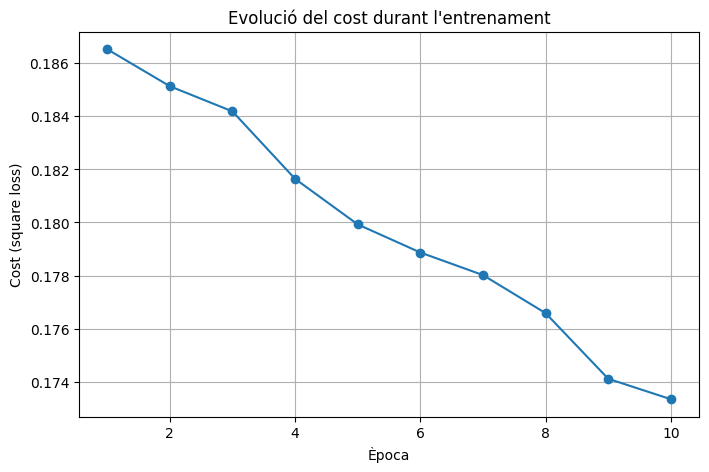

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(1, epochs + 1), cost_history, marker='o')
plt.title("Evolució del cost durant l'entrenament")
plt.xlabel("Època")
plt.ylabel("Cost (square loss)")
plt.grid(True)
plt.savefig("vqc_cost.png", dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_6021/1843587638.py:8: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x, prob, c='blue' if y_true == 0 else 'red', edgecolors='k', s=100, marker='x', linewidths=2)


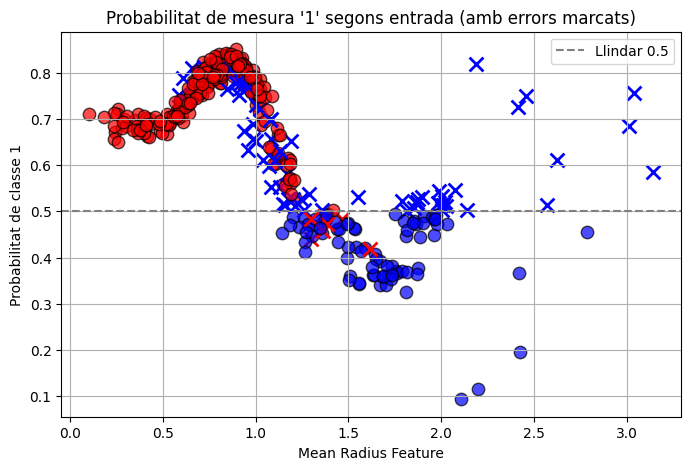

In [44]:
plt.figure(figsize=(8, 5))

# Mostres ben classificades
for x, prob, y_true, y_pred in zip(X_plot, prob_1_plot, y_true_plot, y_pred_plot):
    if y_true == y_pred:
        plt.scatter(x, prob, c='blue' if y_true == 0 else 'red', edgecolors='k', s=80, marker='o', alpha=0.7)
    else:
        plt.scatter(x, prob, c='blue' if y_true == 0 else 'red', edgecolors='k', s=100, marker='x', linewidths=2)

# Referència de la decisió
plt.axhline(0.5, color='gray', linestyle='--', label="Llindar 0.5")

# Etiquetes
plt.title("Probabilitat de mesura '1' segons entrada (amb errors marcats)")
plt.xlabel("Mean Radius Feature")
plt.ylabel("Probabilitat de classe 1")
plt.grid(True)
plt.legend()
plt.savefig("vqc_prob_with_errors.png", dpi=300, bbox_inches='tight')
plt.show()


/tmp/ipykernel_6021/4046996585.py:10: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(xi[0], xi[2], color='red' if y_true == 1 else 'blue',


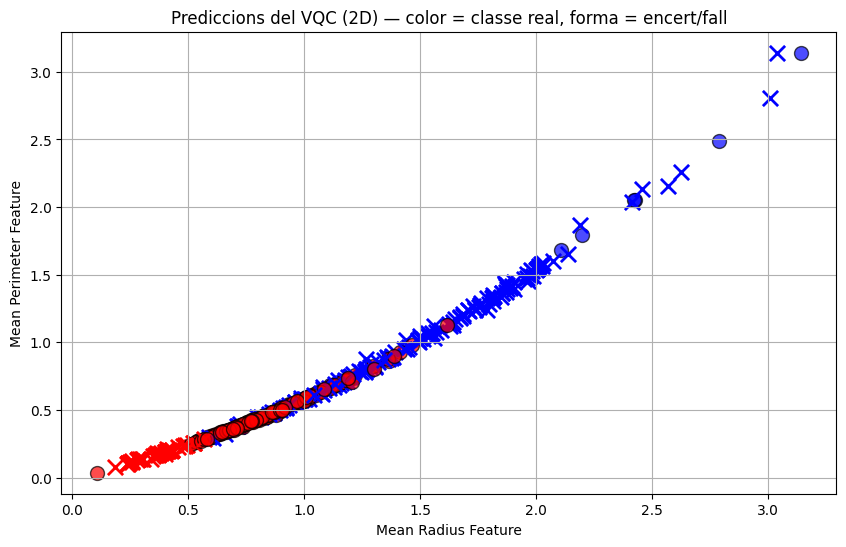

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for xi, y_true, y_pred in zip(X_train, y_true_plot, y_pred_plot):
    if y_true == y_pred:
        plt.scatter(xi[0], xi[2], color='red' if y_true == 1 else 'blue',
                    marker='o', edgecolors='k', s=100, alpha=0.7)
    else:
        plt.scatter(xi[0], xi[2], color='red' if y_true == 1 else 'blue',
                    marker='x', edgecolors='k', s=120, linewidths=2)

plt.title("Prediccions del VQC (2D) — color = classe real, forma = encert/fall")
plt.xlabel("Mean Radius Feature")
plt.ylabel("Mean Perimeter Feature")
plt.grid(True)
plt.savefig("vqc_twof.png", dpi=300, bbox_inches='tight')
plt.show()

In [33]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()

for idx, name in enumerate(data.feature_names):
    print(f"{idx}: {name}")


0: mean radius
1: mean texture
2: mean perimeter
3: mean area
4: mean smoothness
5: mean compactness
6: mean concavity
7: mean concave points
8: mean symmetry
9: mean fractal dimension
10: radius error
11: texture error
12: perimeter error
13: area error
14: smoothness error
15: compactness error
16: concavity error
17: concave points error
18: symmetry error
19: fractal dimension error
20: worst radius
21: worst texture
22: worst perimeter
23: worst area
24: worst smoothness
25: worst compactness
26: worst concavity
27: worst concave points
28: worst symmetry
29: worst fractal dimension


Starting training...
Epoch 1, Cost: 0.2748
Epoch 2, Cost: 0.2747
Epoch 3, Cost: 0.2730
Epoch 4, Cost: 0.2689
Epoch 5, Cost: 0.2653
Epoch 6, Cost: 0.2633
Epoch 7, Cost: 0.2597
Epoch 8, Cost: 0.2571
Epoch 9, Cost: 0.2563
Epoch 10, Cost: 0.2530

Predictions with true labels and accuracy check:

Final accuracy: 215/398 correct (54.02%)


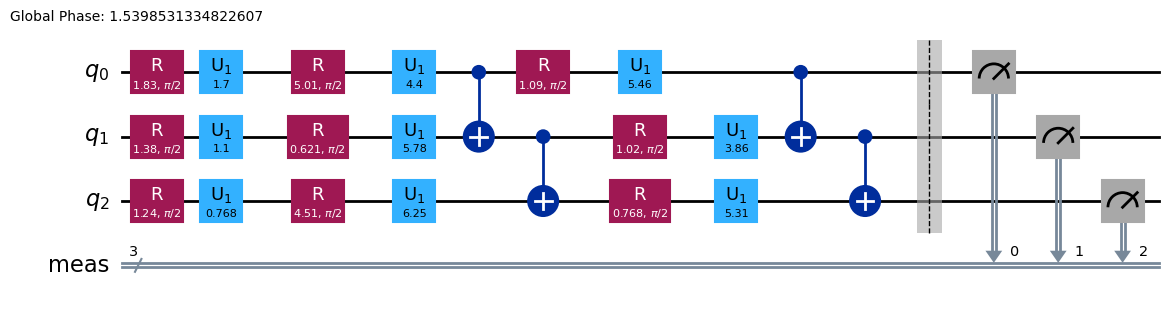

In [47]:
# Carreguem les dades
data = load_breast_cancer()
X = data.data
y = data.target  # 0 = malignant, 1 = benign

# Seleccionem només 2 o 3 features rellevants (per exemple, mean radius i mean texture)
selected_features = [0, 2, 3, 20, 23, 27]  # pots provar altres combinacions
X_selected = X[:, selected_features]

# Normalitzem entre [0, pi] per adaptar-ho a rotacions
scaler = MinMaxScaler(feature_range=(0, np.pi))
X_scaled = scaler.fit_transform(X_selected)

# Partició train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Nombre de qubits segons nombre de features
n_qubits = X_train.shape[1]


n_qubits = 3
num_layers = 2
num_params = num_layers * 2 * n_qubits  # Cada capa té 2 paràmetres per qubit
params = np.random.uniform(0, 2 * np.pi, num_params)

epochs = 10
alpha = 0.1    # Taxa d'aprenentatge
delta = 0.01   # Increment per al gradient numèric
entangle = True  # Entrellaçament activat
cost_history = []


# Configuració del simulador
sim_noise = AerSimulator(noise_model=noise_bit_flip)
pm = generate_preset_pass_manager(backend=sim_noise, optimization_level=1)

sampler = Sampler(mode=sim_noise)
print("Starting training...")
for epoch in range(epochs):
    grads = np.zeros_like(params)
    for i in range(len(params)):
        plus_params = np.copy(params)
        minus_params = np.copy(params)
        plus_params[i] += delta
        minus_params[i] -= delta
        grads[i] = (cost(plus_params, X_train, y_train, sampler, n_qubits, entangle)
                    - cost(minus_params, X_train, y_train, sampler, n_qubits, entangle)) / (2 * delta)
    params -= alpha * grads
    curr_cost = cost(params, X_train, y_train, sampler, n_qubits, entangle)
    cost_history.append(curr_cost)
    print(f"Epoch {epoch + 1}, Cost: {curr_cost:.4f}")

# ---------------------------
# Test i precisió final
# ---------------------------

print("\nPredictions with true labels and accuracy check:")
correct = 0
X_plot = []
y_true_plot = []
y_pred_plot = []
prob_1_plot = []

total = len(X_train)

for xi, yi in zip(X_train, y_train):
    qc = construct_circuit(xi, params, n_qubits, entangle=entangle)
    result = sampler.run([qc]).result()
    bit_array = result[0].data.meas
    counts = bit_array.get_counts()
    total_counts = sum(counts.values())

    prob_1 = sum(count for bitstring, count in counts.items() if bitstring[-1] == '1')
    prob_1 /= total_counts
    predicted_class = int(prob_1 > 0.5)
    X_plot.append(xi[0])  # O xi si vols fer un plot 2D
    y_true_plot.append(yi)
    y_pred_plot.append(predicted_class)
    prob_1_plot.append(prob_1)


    #print(f"Input: {xi}, True class: {yi}, Predicted: {predicted_class}, Probability: {prob_1:.2f}")
    if predicted_class == yi:
        correct += 1

accuracy = correct / total * 100
print(f"\nFinal accuracy: {correct}/{total} correct ({accuracy:.2f}%)")

# ---------------------------
# Visualització del circuit final
# ---------------------------

qc_test = construct_circuit(X_train[0], params, n_qubits, entangle=entangle)
qc_test.decompose().draw('mpl')

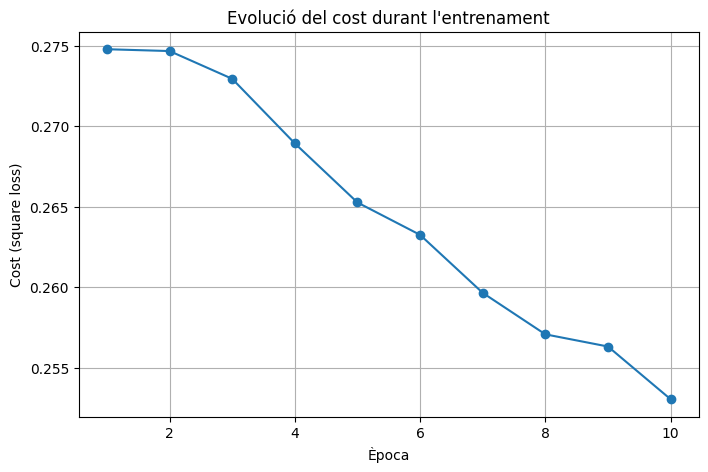

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(1, epochs + 1), cost_history, marker='o')
plt.title("Evolució del cost durant l'entrenament")
plt.xlabel("Època")
plt.ylabel("Cost (square loss)")
plt.grid(True)
plt.savefig("vqc_noise_cost.png", dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_6021/262776146.py:8: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x, prob, c='blue' if y_true == 0 else 'red', edgecolors='k', s=100, marker='x', linewidths=2)


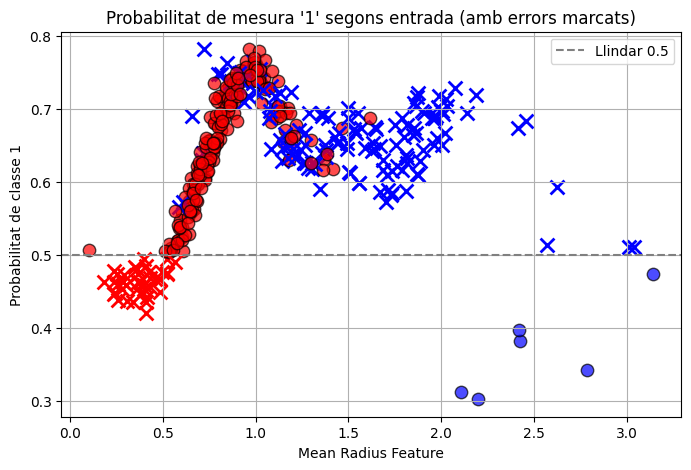

In [50]:
plt.figure(figsize=(8, 5))

# Mostres ben classificades
for x, prob, y_true, y_pred in zip(X_plot, prob_1_plot, y_true_plot, y_pred_plot):
    if y_true == y_pred:
        plt.scatter(x, prob, c='blue' if y_true == 0 else 'red', edgecolors='k', s=80, marker='o', alpha=0.7)
    else:
        plt.scatter(x, prob, c='blue' if y_true == 0 else 'red', edgecolors='k', s=100, marker='x', linewidths=2)

# Referència de la decisió
plt.axhline(0.5, color='gray', linestyle='--', label="Llindar 0.5")

# Etiquetes
plt.title("Probabilitat de mesura '1' segons entrada (amb errors marcats)")
plt.xlabel("Mean Radius Feature")
plt.ylabel("Probabilitat de classe 1")
plt.grid(True)
plt.legend()
plt.savefig("vqc_noise_prob_with_errors.png", dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_6021/3167042052.py:10: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(xi[0], xi[2], color='red' if y_true == 1 else 'blue',


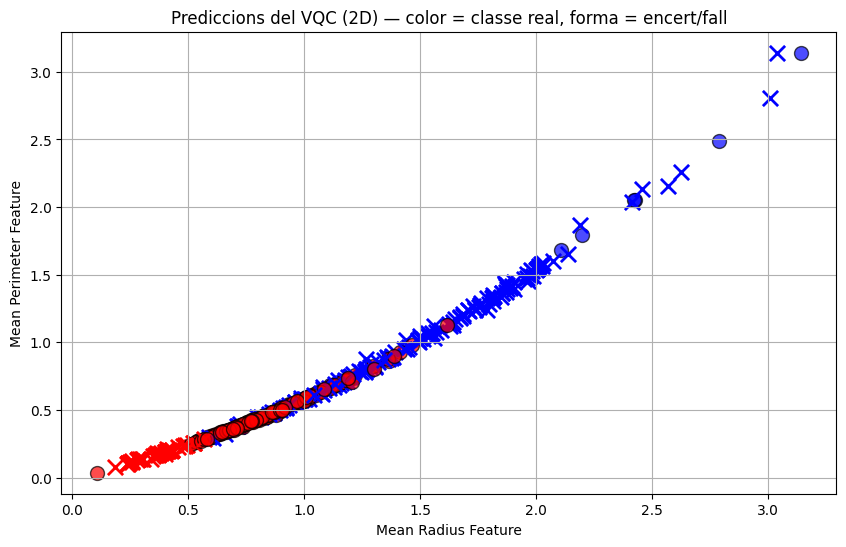

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for xi, y_true, y_pred in zip(X_train, y_true_plot, y_pred_plot):
    if y_true == y_pred:
        plt.scatter(xi[0], xi[2], color='red' if y_true == 1 else 'blue',
                    marker='o', edgecolors='k', s=100, alpha=0.7)
    else:
        plt.scatter(xi[0], xi[2], color='red' if y_true == 1 else 'blue',
                    marker='x', edgecolors='k', s=120, linewidths=2)

plt.title("Prediccions del VQC (2D) — color = classe real, forma = encert/fall")
plt.xlabel("Mean Radius Feature")
plt.ylabel("Mean Perimeter Feature")
plt.grid(True)
plt.savefig("vqc_noise_twof.png", dpi=300, bbox_inches='tight')
plt.show()